To get started we first have to import the libraries we need

In [ ]:
#Load the libraries we need
import pandas as pd
import numpy as np
import MetaTrader5 as mt5
from sklearn.model_selection import TimeSeriesSplit,cross_val_score
from sklearn.linear_model import LogisticRegression,LinearRegression
import matplotlib.pyplot as plt

In [ ]:
#Initialize the terminal
mt5.initialize()

True

In [ ]:
#The total number of symbols we have
print(f"Total Symbols Available: ",mt5.symbols_total())

Total Symbols Available:  297


In [ ]:
#Get the names of all pairs
symbols = mt5.symbols_get()
idx = [s.name for s in symbols]

In [ ]:
global_params = pd.DataFrame(index=idx,columns=["OHLC Error","MAR Error","Noise Levels","Divergence Error"])
global_params

OHLC Error MAR Error Noise Levels Divergence Error
AUDCAD                             NaN       NaN          NaN              NaN
AUDCHF                             NaN       NaN          NaN              NaN
AUDNZD                             NaN       NaN          NaN              NaN
AUDJPY                             NaN       NaN          NaN              NaN
AUDUSD                             NaN       NaN          NaN              NaN
...                                ...       ...          ...              ...
Vol over Crash 550                 NaN       NaN          NaN              NaN
Silver RSI Rebound Index           NaN       NaN          NaN              NaN
Silver RSI Pullback Index          NaN       NaN          NaN              NaN
Silver RSI Trend Up Index          NaN       NaN          NaN              NaN
Silver RSI Trend Down Index        NaN       NaN          NaN              NaN

[297 rows x 4 columns]

In [ ]:
#Define the time series split object
tscv = TimeSeriesSplit(n_splits=5,gap=10)

In [ ]:
#Iterate over all symbols
for i in np.arange(global_params.dropna().shape[0],len(idx)):
    #Fetch M1 Data
    data = pd.DataFrame(mt5.copy_rates_from_pos(cols[i],mt5.TIMEFRAME_M1,0,50000))
    data.rename(columns={"open":"Open","high":"High","low":"Low","close":"Close"},inplace=True)
    #Label the data
    data["OHLC Target"] = 0
    data["New Target"]  = 0
    data["Divergence Target"]  = 0
    #Define our period
    period = 10
    #Add the classical target
    data.loc[data["Close"].shift(-period) > data["Close"],"OHLC Target"] = 1
    #Calculate the returns
    data.loc[:,["Open","High","Low","Close"]] = data.loc[:,["Open","High","Low","Close"]].diff(period)
    data["RMA"] = data["Close"].rolling(period).mean()
    #Calculate our new target
    data.dropna(inplace=True)
    data.reset_index(inplace=True,drop=True)
    data.loc[data["RMA"].shift(-period) > data["RMA"],"New Target"] = 1
    data = data.iloc[0:-period,:]
    #Calculate the divergence target
    data.loc[data["OHLC Target"] != data["New Target"],"Divergence Target"] = 1
    #Noise ratio
    global_params.iloc[i,2] = data.loc[data["New Target"] != data["OHLC Target"]].shape[0] / data.shape[0]
    #Test our accuracy predicting the future close price
    score = cross_val_score(LogisticRegression(),data.loc[:,["Open","High","Low","Close"]],data["OHLC Target"],cv=tscv)
    global_params.iloc[i,0] = score.mean()
    #Test our accuracy predicting the moving average of future returns
    score = cross_val_score(LogisticRegression(),data.loc[:,["Open","Close","RMA"]],data["New Target"],cv=tscv)
    global_params.iloc[i,1] = score.mean()
    #Test our accuracy predicting the future divergence between price and its moving average
    score = cross_val_score(LogisticRegression(),data.loc[:,["Open","Close","RMA"]],data["Divergence Target"],cv=tscv)
    global_params.iloc[i,3] = score.mean()
    print(f"{((i/len(idx)) * 100)}% complete")

#We are done
print("Done")

90.9090909090909% complete
91.24579124579124% complete
91.58249158249158% complete
91.91919191919192% complete
92.25589225589226% complete
92.5925925925926% complete
92.92929292929293% complete
93.26599326599326% complete
93.60269360269359% complete
93.93939393939394% complete
94.27609427609428% complete
94.61279461279462% complete
94.94949494949495% complete
95.28619528619528% complete
95.62289562289563% complete
95.95959595959596% complete
96.29629629629629% complete
96.63299663299664% complete
96.96969696969697% complete
97.3063973063973% complete
97.64309764309765% complete
97.97979797979798% complete
98.31649831649831% complete
98.65319865319864% complete
98.98989898989899% complete
99.32659932659934% complete
99.66329966329967% complete
Done


In [ ]:
global_params.iloc[0:0,:]

Empty DataFrame
Columns: [OHLC Error, MAR Error, Noise Levels, Divergence Error]
Index: []

In [ ]:
global_params.to_csv("global params.csv")

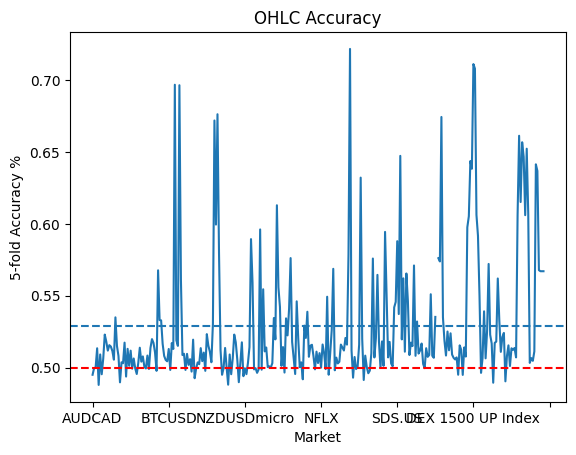

In [ ]:
global_params.iloc[:,0].plot()
plt.title("OHLC Accuracy")
plt.xlabel("Market")
plt.ylabel("5-fold Accuracy %")
plt.axhline(global_params.iloc[:,0].mean(),linestyle='--')
plt.axhline(0.5,linestyle='--',color='red')

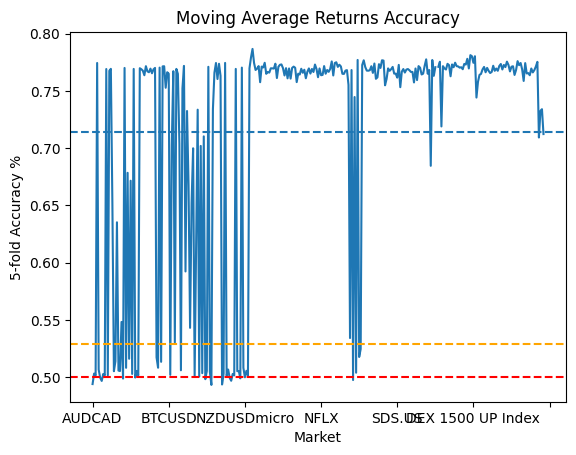

In [ ]:
global_params.iloc[:,1].plot()
plt.title("Moving Average Returns Accuracy")
plt.xlabel("Market")
plt.ylabel("5-fold Accuracy %")
plt.axhline(global_params.iloc[:,1].mean(),linestyle='--')
plt.axhline(global_params.iloc[:,0].mean(),linestyle='--',color='orange')
plt.axhline(0.5,linestyle='--',color='red')

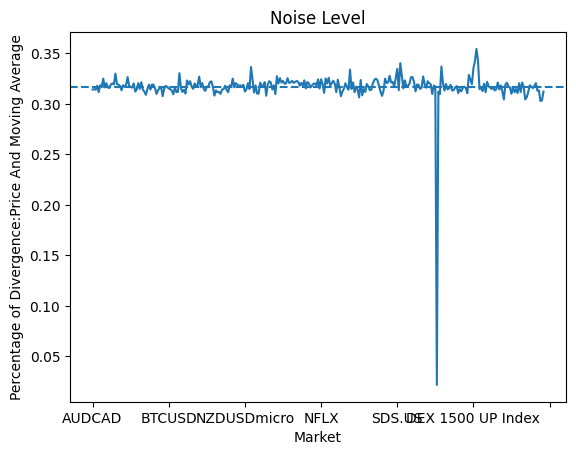

In [ ]:
global_params.iloc[:,2].plot()
plt.title("Noise Level")
plt.xlabel("Market")
plt.ylabel("Percentage of Divergence:Price And Moving Average")
plt.axhline(global_params.iloc[:,2].mean(),linestyle='--')

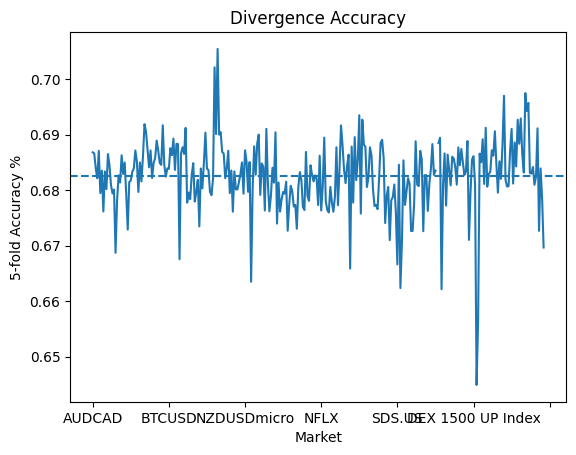

In [ ]:
global_params.iloc[:,3].plot()
plt.title("Divergence Accuracy")
plt.xlabel("Market")
plt.ylabel("5-fold Accuracy %")
plt.axhline(global_params.iloc[:,3].mean(),linestyle='--')

In [ ]:
global_params.mean()

OHLC Error          0.525353
MAR Error           0.705468
Noise Levels        0.317187
Divergence Error    0.682069
dtype: object

In [ ]:
global_params.var()

OHLC Error          0.001788
MAR Error           0.011672
Noise Levels        0.000386
Divergence Error    0.000041
dtype: object

In [ ]:
global_params = pd.read_csv("global params.csv")

In [ ]:
global_params.sort_values("MAR Error",ascending=False)

Unnamed: 0  OHLC Error  MAR Error  Noise Levels  \
105      Range Break 200 Index    0.559102   0.786695      0.323748   
248         DEX 900 DOWN Index    0.643636   0.781244      0.324168   
249           DEX 900 UP Index    0.638305   0.780379      0.319425   
251        DEX 1500 DOWN Index    0.707901   0.780307      0.342198   
104      Range Break 100 Index    0.589361   0.779299      0.336495   
..                         ...         ...        ...           ...   
6                       EURCAD    0.495413   0.496830      0.316584   
0                       AUDCAD    0.495053   0.494092      0.314162   
85                 AUDCADmicro    0.495053   0.493732      0.314162   
78                      USDSGD    0.503746   0.493348      0.322307   
226  Volatility 300 (1s) Index         NaN        NaN      0.021813   

     Divergence Error  
105          0.680355  
248          0.679467  
249          0.685495  
251          0.680980  
104          0.663497  
..                ...  
6            0.683501  
0            0.686792  
85           0.686864  
78           0.679083  
226               NaN  

[297 rows x 5 columns]

In [ ]:
symbol = "Range Break 200 Index"

In [ ]:
data = pd.DataFrame(mt5.copy_rates_from_pos(symbol,mt5.TIMEFRAME_M1,0,300000))

In [ ]:
data.to_csv("Range Break 200 Index.csv")